# Analisador de Fake News


## Problemática
O atual cenário político-social mundial tem se mostrado fortemente impactado pela **disseminação de Fake News**, as quais vem ganhando bastante **notoriedade com o crescente uso de redes sociais** e divulgação das mesmas nesses meios.

Visto que as fakes news **acabam servindo como um meio de alienar a população**, o presente notebook possui o objetivo de **elaborar um modelo que possa classificar se determinada notícia é verdadeira ou falsa**, consistindo **ao todo em 4009 registros de notícias**, sendo 2137 notícias falsas e 1872 notícias verdadeiras.

Aqui utilizaremos os seguintes algoritmos de aprendizagem de máquina para elaboração do nosso modelo:
> - Regressão Logística
> - KNN
> - Análise Discriminante Gaussiano
> - Árvore de Decisão
> - SVM
> - Random Forest


## Fonte dos Dados
O dataset utilizado para este problema foi retirado do [Kaggle]( https://www.kaggle.com/jruvika/fake-news-detection), fruto de um web crawler de diferentes fontes americanas, consiste em **4009 registros de notícias**, sendo **2137 notícias falsas** e **1872 notícias verdadeiras**.

## Sumário
#### 1. Importações
#### 2. Leitura dos Dados
#### 3. Limpeza e Transformações dos Dados
#### 4. Redução de Dimensionalidade dos Dados
#### 5. Visualizações dos dados
#### 6. Avaliação dos Modelos
#### 7. Avaliação de Resultados e Conclusão

# 1. Importações

In [18]:
import numpy as np
import pandas as pd
import warnings
import seaborn as sb
from statistics import mean
from scipy.linalg import svd 
from math import log, pi, sqrt
import matplotlib.pyplot as plt
from operator import itemgetter
%matplotlib inline

# Tratamento do Texto
from textblob import TextBlob, Word
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from scipy.linalg import svd 
from sklearn import linear_model, datasets, svm, metrics
from scipy.stats import multivariate_normal
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import DistanceMetric, KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from modelos import distance_euclidian, distance_manhattan, fitAD, fitAGD, fitRF, fitRL, fitSVM, getClasses, predict1AGD, predict1KNN, predictAD, predictAGD, predictKNN, predictRF, predictRL, predictSVM, sigmoide 
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
stop = stopwords.words('english')
warnings.filterwarnings("ignore")
np.random.seed(12345)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/andrezafernandes/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/andrezafernandes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andrezafernandes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2. Leitura dos Dados

In [2]:
dataset = pd.read_csv("data/data.csv") # será utilizado para computar coisas nas visualizações
dataset['Body'] = dataset['Body'].astype(str) 
data = dataset # será limpado e utilizado nos modelos
data.head()

,URLs,Headline,Body,Label
0,http://www.bbc.com/news/world-us-canada-414191...,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,1
1,https://www.reuters.com/article/us-filmfestiva...,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",1
2,https://www.nytimes.com/2017/10/09/us/politics...,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,1
3,https://www.reuters.com/article/us-mexico-oil-...,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,1
4,http://www.cnn.com/videos/cnnmoney/2017/10/08/...,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",1


# 3. Limpeza dos Dados

In [3]:
# Deixar tudo em lower case
data['Headline'] = data['Headline'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data['Body'] = data['Body'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))
# Removendo pontuação
data['Headline'] = data['Headline'].str.replace('[^\w\s]','')
data['Body'] = data['Body'].str.replace('[^\w\s]','')
# Removendo stopwords
data['Headline'] = data['Headline'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
data['Body'] = data['Body'].apply(lambda x: " ".join(x for x in str(x).split() if str(x) not in stop))
# 10 Palavras mais frequentes e menos frequentes
freqHeadline = pd.Series(' '.join(data['Headline']).split()).value_counts()[:10]
freqBody = pd.Series(' '.join(data['Body']).split()).value_counts()[:10]
rareHead = pd.Series(' '.join(data['Headline']).split()).value_counts()[-10:]
rareBody = pd.Series(' '.join(data['Body']).split()).value_counts()[-10:]
# Remoção das palavras raras e frequentes
freqHeadline = list(freqHeadline.index)
freqBody = list(freqBody.index)
data['Headline'] = data['Headline'].apply(lambda x: " ".join(x for x in x.split() if x not in freqHeadline))
data['Body'] = data['Body'].apply(lambda x: " ".join(x for x in x.split() if x not in freqBody))
data['Headline'] = data['Headline'].apply(lambda x: " ".join(x for x in x.split() if x not in rareHead))
data['Body'] = data['Body'].apply(lambda x: " ".join(x for x in x.split() if x not in rareBody))
# Lemmatization. Extrai o núcleo/root da palavra
data['Headline'] = data['Headline'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
data['Body'] = data['Body'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
data.head()

,URLs,Headline,Body,Label
0,http://www.bbc.com/news/world-us-canada-414191...,four way bob corker skewered donald,image copyright getty image sunday morning don...,1
1,https://www.reuters.com/article/us-filmfestiva...,linklaters war veteran comedy speaks modern am...,london reuters last flag flying comedydrama vi...,1
2,https://www.nytimes.com/2017/10/09/us/politics...,trump fight corker jeopardizes legislative agenda,feud broke public view last week mr corker mr ...,1
3,https://www.reuters.com/article/us-mexico-oil-...,egypt cheiron win tieup pemex mexican onshore ...,mexico city reuters egypt cheiron holding limi...,1
4,http://www.cnn.com/videos/cnnmoney/2017/10/08/...,jason aldean open snl tribute,country singer jason aldean performing la vega...,1


In [4]:
vectorizer = CountVectorizer()
vectorizer.fit(data['Headline']) # tokenize and build vocabulary
vector = vectorizer.transform(data['Headline']) # encode document
print("Tamanho: ", vector.shape)
head = [key for key in  vectorizer.vocabulary_]
df = pd.DataFrame(vector.toarray(), columns = head)
df['Label'] = data['Label']
df.head()

Tamanho:  (4009, 6633)


,four,way,bob,corker,skewered,donald,linklaters,war,veteran,comedy,...,tragic,hervé,leroux,léger,bandage,dress,30minute,100000,antiamerican,Label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


# 4. Redução da Dimensionalidade

In [5]:
def fisher_score(x, y):
    mean = np.mean(x, axis=0)
    classes = np.unique(y)
    sS = 0
    sD = 0
    Nk = []
    
    meanD = []
    varD = []
    
    for k in classes:
        elements = []
        s = 0
        for i in range(0, len(y)):
            if(y[i] == k):
                s += 1
                elements.append(x[i])
        meanD.append(np.mean(elements, axis=0))
        varD.append(np.var(elements, axis=0))
        Nk.append(s)
    
    for k in range(0, len(classes)):
        sS += (Nk[k] * ((meanD[k] - mean)**2))
        sD += (Nk[k] * varD[k])
    return sS/sD

def compute(x):
    mean = np.mean(x, axis = 0)
    cov = np.cov(np.transpose(x))

    U, S, V = svd(cov)
    S = np.diag(S)
    M = U @ S @ V
    P = np.transpose(U)
    return {'S': S, 'U': U, 'V': V, 'M': M, 'P': P}

def transform(x, rateVariance):
    pca_result = compute(x)
    
    S = pca_result['S']
    P = pca_result['P']
    
 #   autovalores = np.sort([S[i][i] for i in range(len(S))])[::-1]
    #varianciaExplicadaTot = np.sum(np.array(autovalores))
    #varianceExpl = rateVarience*varianciaExplicadaTot

    #matrizTransform = []
    
    matrizTransform = []
    varianciaExplicadaTot = 0
    varianceExpl = 0
    autoValores = []
    for i in range(0, S.shape[0]):
        varianciaExplicadaTot += S[i,i]
        autoValores.append(S[i,i])
    varianceExpl = rateVariance *varianciaExplicadaTot

    autoValOrdenados = np.sort(autoValores)
    autoValOrdenados = autoValOrdenados[::-1]
    
    varianceAtual = 0
    i = 0
    while(varianceAtual<=varianceExpl and i<autoValOrdenados.shape[0]):
        for j in range (0, len(autoValores)):
            if(autoValOrdenados[i]==autoValores[j]):
                matrizTransform.append(P[j])
        varianceAtual += autoValOrdenados[i]
        i += 1
    return {'P': matrizTransform, 'Z':np.transpose(np.dot(matrizTransform, np.transpose(x)))}

In [7]:
resultPCA = transform(df.values[:,0:-1], 0.9)

In [8]:
dataPCA = np.hstack((resultPCA['Z'], df.values[:,-1][:,None]))
matrizPCA = resultPCA['P']

In [9]:
fisher_scores = fisher_score(dataPCA[:,0:-1], dataPCA[:,-1])
qnt = 1000 # quantas colunas quer dropar pelo fisher score
indices = [] # armazena os indices dos menores valores do fisher_score -> que é o que vamos dropar
for i in range(qnt): # faz o processamento de armazenar os indices dos menores valores
    indice = np.argmin(fisher_scores)
    fisher_scores[indice] = 10000
    indices.append(indice)

dataPCA = pd.DataFrame(dataPCA)
data_fisher = dataPCA.drop([dataPCA.columns[i] for i in indices] ,  axis='columns')
data_fisher.head()
#classes, ocorrencs = np.unique(indices, return_counts=True)
#dict(zip(classes, ocorrencs))

,0,1,2,3,4,5,6,9,10,11,...,1383,1384,1391,1396,1400,1408,1417,1432,1442,1444
0,0.025691,-0.024908,-0.033540,-0.035619,-0.019977,0.013167,-0.043963,0.347895,0.115632,0.209160,...,-0.002453,0.014982,-0.010635,-0.011932,0.004012,0.018688,-0.005193,-0.013681,-0.012413,1.0
1,-0.027007,-0.010447,-0.018250,0.002831,-0.020737,0.010318,-0.005501,0.087283,0.024936,-0.015843,...,0.025791,-0.009227,-0.049659,0.004075,0.018935,-0.031603,-0.034819,0.013850,-0.001363,1.0
2,-0.030487,-0.036350,-0.050334,0.012354,-0.020439,-0.060538,-0.003551,0.513610,0.173663,0.247610,...,-0.098727,0.026620,0.001825,-0.009915,-0.030626,-0.023182,0.024784,0.070085,-0.018685,1.0
3,0.748006,0.052074,0.001575,0.219412,-0.555058,-0.048646,0.136219,-0.171092,0.225037,0.103097,...,0.073038,-0.009118,-0.015282,-0.012793,-0.037303,-0.027757,0.011163,-0.028900,0.011526,1.0
4,-0.017513,-0.019155,-0.030973,0.002875,-0.009002,-0.039691,0.032445,-0.058962,0.003108,-0.023746,...,0.003392,0.007264,-0.020214,-0.022187,0.004710,-0.000582,-0.006157,-0.028282,0.003698,1.0


# 5. Visualização e Análise dos dados

0. dataset.describe()
0. dataset.corr()

0. WordCloud

1. Palavras mais frequentes por classe - sem stopwords - (grafico de barras)
2. Palavras menos frequentes por classe - sem stopwords - (grafico de barras)



In [9]:
#usar dataset pós-limpeza
dataset = data

titulosFake = ""
titulosReal = ""
for i in range(0, dataset.shape[0]):
    if (dataset['Label'][i]==1):
        titulosFake += dataset['Headline'][i]+" "
    else:
        titulosReal += dataset['Headline'][i]+" "

In [10]:
wordsFake = titulosFake.split()
wordsReal = titulosReal.split()

distinctFake = []
distinctReal = []
for i in wordsFake:
    if i not in distinctFake:
        distinctFake.append(i)
for i in wordsReal:
    if i not in distinctReal:
        distinctReal.append(i)


countFake = []
countReal = []
for i in distinctFake:
    cont = 0
    for j in wordsFake:
        if (i==j):
            cont += 1
    countFake.append(cont)
for i in distinctReal:
    cont = 0
    for j in wordsReal:
        if (i==j):
            cont += 1
    countReal.append(cont)
    
dictFake = {}
for i in range(0, len(distinctFake)):
    dictFake[distinctFake[i]] =  countFake[i]
    
dictFake = sorted(dictFake.items(), key=itemgetter(1), reverse=True)

dictReal = {}
for i in range(0, len(distinctReal)):
    dictReal[distinctReal[i]] =  countReal[i]

dictReal = sorted(dictReal.items(), key=itemgetter(1), reverse=True)

wordsFake = []
wordsReal = []
contFake = []
contReal = []
for i in range(0, 15):
    wordsFake.append(dictFake[i][0])
    contFake.append(dictFake[i][1])
    wordsReal.append(dictReal[i][0])
    contReal.append(dictReal[i][1])

## 5.1. WordCloud Fake News

In [ ]:
wordcloud = WordCloud(max_font_size=100).generate(titulosFake)
plt.figure(figsize=(12,8)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('WordCloudtMostFrequencyFakeNews.png')
plt.show()


In [ ]:
plt.figure(figsize=(12,8)) 
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
#plt.bar(wordsFake, contFake, color="blue")
rects = plt.bar(wordsFake, contFake, align='center', alpha=0.5)
plt.ylabel('Number')
plt.title('Most popular words in Fake News')
for bar in rects:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval+1, yval, fontsize=12)
plt.savefig('BarChartMostFrequencyFakeNews.png')
plt.show()


## 5.2. WordCloud Notícias Reais

In [ ]:
wordcloud = WordCloud(max_font_size=100).generate(titulosReal)
plt.figure(figsize=(12,8)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('WordCloudtMostFrequencyRealNews.png')
plt.show()


In [ ]:
#plt.bar(wordsReal, contReal, color="red")

plt.figure(figsize=(12,8)) 
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
#plt.bar(wordsFake, contFake, color="blue")
rects = plt.bar(wordsReal, contReal, align='center', alpha=0.5, color = "orange")
plt.ylabel('Number')
plt.title('Most popular words in True News')
for bar in rects:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval+1, yval, fontsize=12)
plt.savefig('BarChartMostFrequencyRealNews.png')
plt.show()


# 6. Avaliação de Métodos

In [13]:
# Split dos Dados
# atribuindo X com as features e y com os valores de classe
X = data_fisher.values[:,:-1]
Y = data_fisher.values[:,-1]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25)

In [14]:
def acc(y_test, results):
    tot = [1 for x,z in zip(y_test,results) if x == z]
    return (np.sum(np.array(tot))/len(y_test))*100

## 6.1 Regressão Logística

In [24]:
# atribuindo X com as features e y com os valores de classe
y_pred = predictRL(fitRL(x_train, y_train, 1000, 0.001)[0], x_test)
print("[Regressão Logística] Score")
acc(y_test, y_pred)

[Regressão Logística] Treinando modelo...
[Regressão Logística] Testando modelo...
[Regressão Logística] Score


52.043868394815554

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.52      1.00      0.68       522
         1.0       0.00      0.00      0.00       481

    accuracy                           0.52      1003
   macro avg       0.26      0.50      0.34      1003
weighted avg       0.27      0.52      0.36      1003



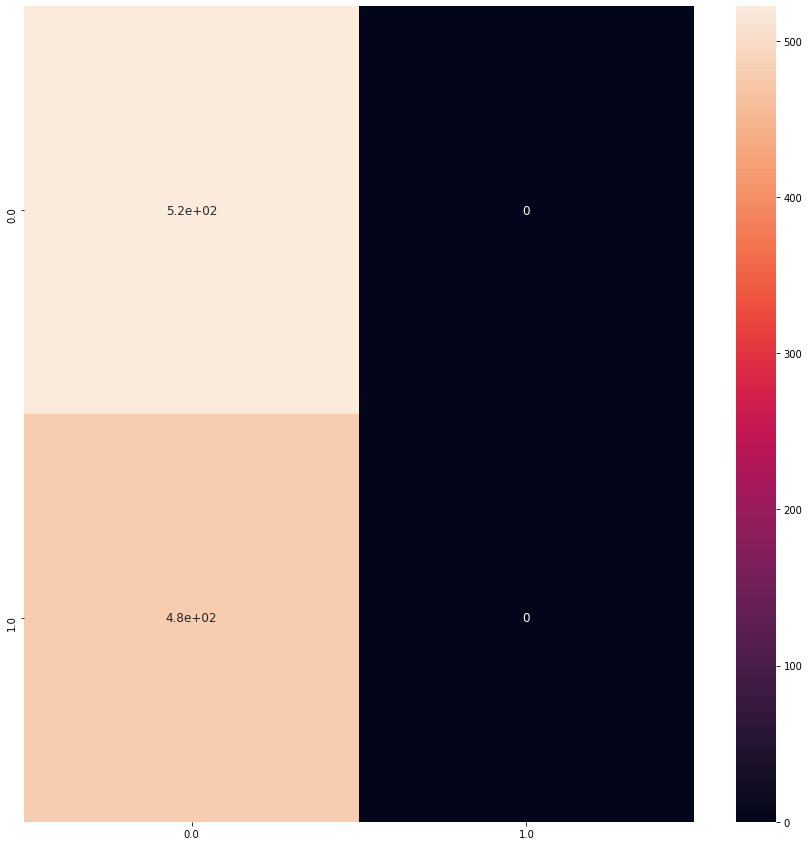

In [26]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index = np.unique(y_test), columns = np.unique(y_test))

plt.figure(figsize=(15,15))
sb.heatmap(cm_df, annot=True, annot_kws={"size": 12})
plt.savefig('RegLog.png')

## 6.2. Análise Discriminante Gaussiano

In [27]:
y_pred = predictAGD(fitAGD(x_train, y_train), x_test)
print("[Análise Discriminante Gaussiano] Score")
acc(y_test, y_pred)

[Análise Discriminante Gaussiana] Treinando modelo...
[Análise Discriminante Gaussiana] Testando modelo...
[Análise Discriminante Gaussiano] Score


83.34995014955135

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.90      0.77      0.83       522
         1.0       0.78      0.91      0.84       481

    accuracy                           0.83      1003
   macro avg       0.84      0.84      0.83      1003
weighted avg       0.84      0.83      0.83      1003



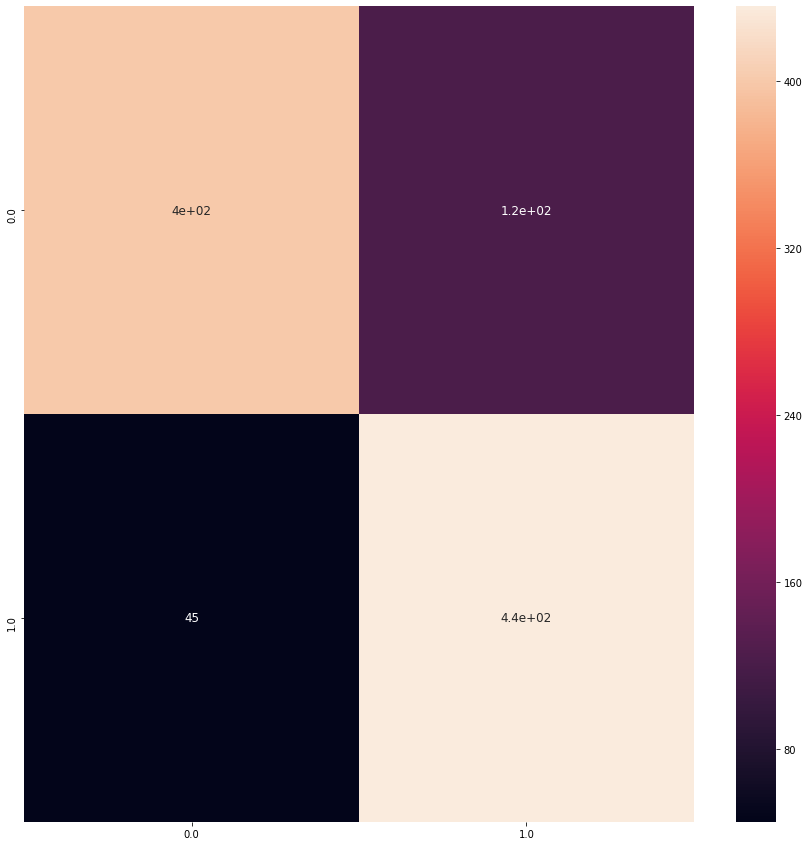

In [29]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index = np.unique(y_test), columns = np.unique(y_test))

plt.figure(figsize=(15,15))
sb.heatmap(cm_df, annot=True, annot_kws={"size": 12})
plt.savefig('AGD.png')

## 6.3. Árvore de Decisão

In [30]:
y_pred = predictAD(fitAD(x_train, y_train, 'gini', 3), x_train, y_train, x_test)
print("[Árvore de Decisão] Score")
acc(y_test, y_pred)


[Árvore de Decisão] Selecionando hiperparâmetros...
[Árvore de Decisão] Treinando modelos...
Parâmetros escolhidos para Árvore de Decisão:  {'criterion': 'entropy', 'max_depth': 49}
[Árvore de Decisão] Testando modelos...
[Árvore de Decisão] Score


74.67597208374876

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.74      0.80      0.77       522
         1.0       0.76      0.69      0.72       481

    accuracy                           0.75      1003
   macro avg       0.75      0.74      0.74      1003
weighted avg       0.75      0.75      0.75      1003



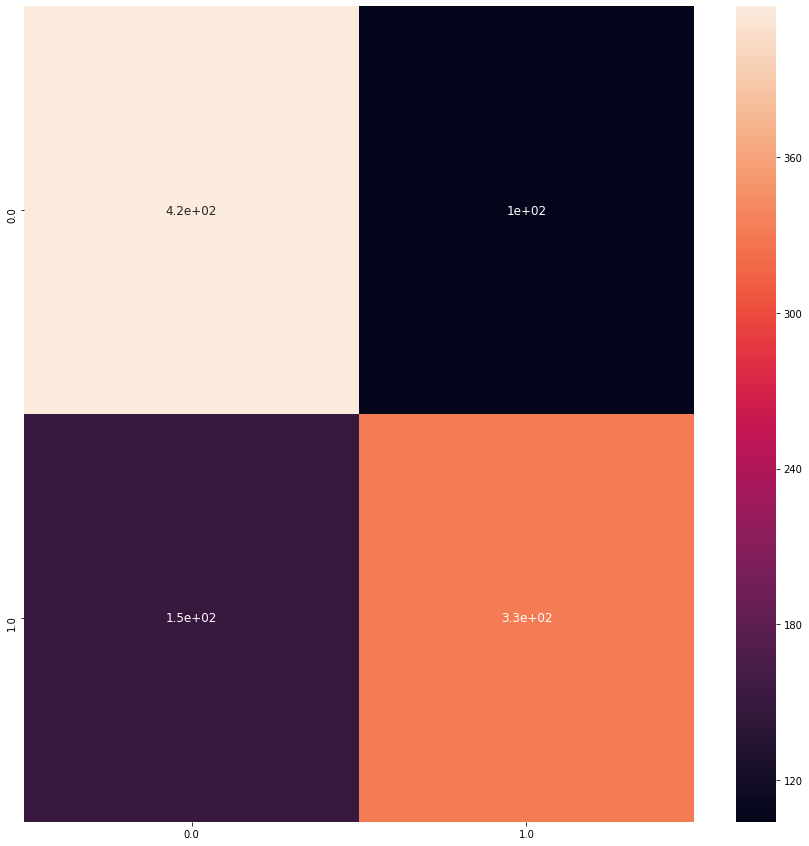

In [32]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index = np.unique(y_test), columns = np.unique(y_test))

plt.figure(figsize=(15,15))
sb.heatmap(cm_df, annot=True, annot_kws={"size": 12})
plt.savefig('AD.png')

## 6.4. SVM

In [35]:
y_pred = predictSVM(fitSVM(x_train, y_train), x_train, y_train, x_test)
print("[SVM] Score")
acc(y_test,y_pred)

[SVM] Selecionando hiperparâmetros...
ô merda
GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': array([3.1250e-02, 1.2500e-01...
       3.2000e+01, 1.2800e+02, 5.1200e+02, 2.0480e+03, 8.1920e+03,
       3.2768e+04]),
                          'degree': array([2, 3, 4, 5]), 'kernel': ['poly']},
                         {'C': array([3.1250e-02, 1.2500e-01, 5.0000e-01, 2.0000e+00, 8.0000e+00,
       3.2000e+01, 1.2800e+02, 5.1200e+02, 2.0480e+03, 8.1920e+03,
       3.2768e+04]),
                          'kernel': ['linear']}],
             pre_dispatch='2*n_

88.63409770687937

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89       522
         1.0       0.89      0.87      0.88       481

    accuracy                           0.89      1003
   macro avg       0.89      0.89      0.89      1003
weighted avg       0.89      0.89      0.89      1003



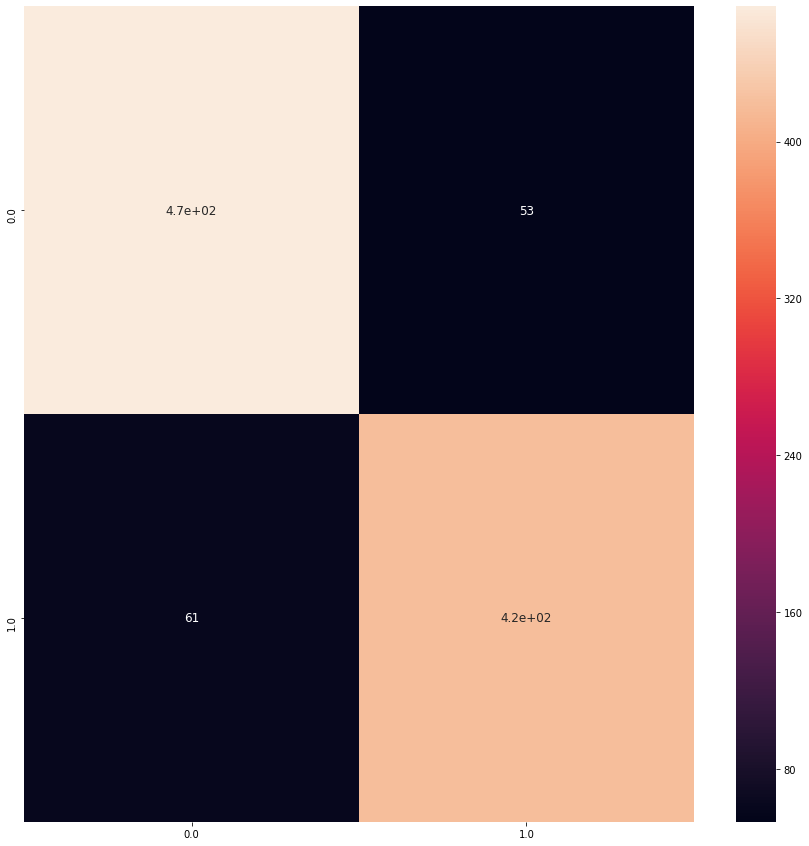

In [37]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index = np.unique(y_test), columns = np.unique(y_test))

plt.figure(figsize=(15,15))
sb.heatmap(cm_df, annot=True, annot_kws={"size": 12})
plt.savefig('SVM.png')

## 6.5. Random Forest

In [19]:
y_pred = predictRF(fitRF(x_train, y_train,'gini', 100, 5), x_train, y_train, x_test)
acc(y_test, y_pred)

[RANDOM FOREST] Selecionando hiperparâmetros...
[RANDOM FOREST] Treinando modelo...
[RANDOM FOREST] Hiperparâmetros escolhidos para Radom Forest:  {'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 146}
[RANDOM FOREST] Testando modelo...


81.95413758723828

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.75      0.81       529
         1.0       0.76      0.89      0.82       474

    accuracy                           0.82      1003
   macro avg       0.83      0.82      0.82      1003
weighted avg       0.83      0.82      0.82      1003



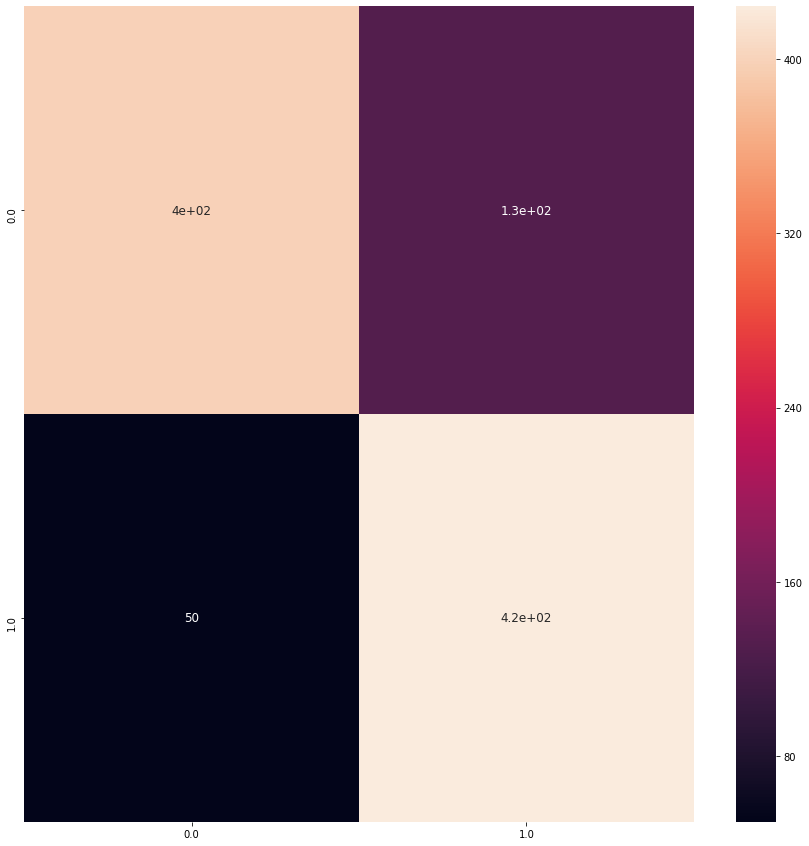

In [21]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index = np.unique(y_test), columns = np.unique(y_test))

plt.figure(figsize=(15,15))
sb.heatmap(cm_df, annot=True, annot_kws={"size": 12})
plt.savefig('RF.png')

## 6.6. KNN

[KNN] Treinando modelo...
[KNN] Testando modelo...
[KNN] Score K =  3
              precision    recall  f1-score   support

         0.0       0.62      0.89      0.73       529
         1.0       0.77      0.39      0.51       474

    accuracy                           0.65      1003
   macro avg       0.69      0.64      0.62      1003
weighted avg       0.69      0.65      0.63      1003

[KNN] Treinando modelo...
[KNN] Testando modelo...
[KNN] Score K =  5
              precision    recall  f1-score   support

         0.0       0.59      0.95      0.73       529
         1.0       0.81      0.26      0.39       474

    accuracy                           0.62      1003
   macro avg       0.70      0.60      0.56      1003
weighted avg       0.69      0.62      0.57      1003

[KNN] Treinando modelo...
[KNN] Testando modelo...
[KNN] Score K =  7
              precision    recall  f1-score   support

         0.0       0.57      0.96      0.72       529
         1.0       0.82    

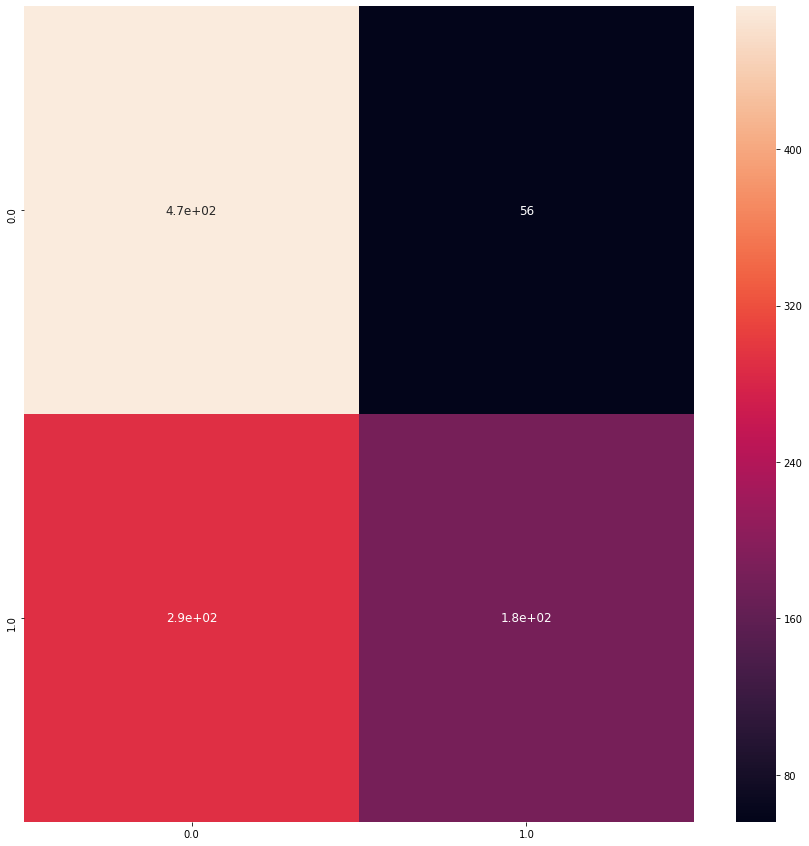

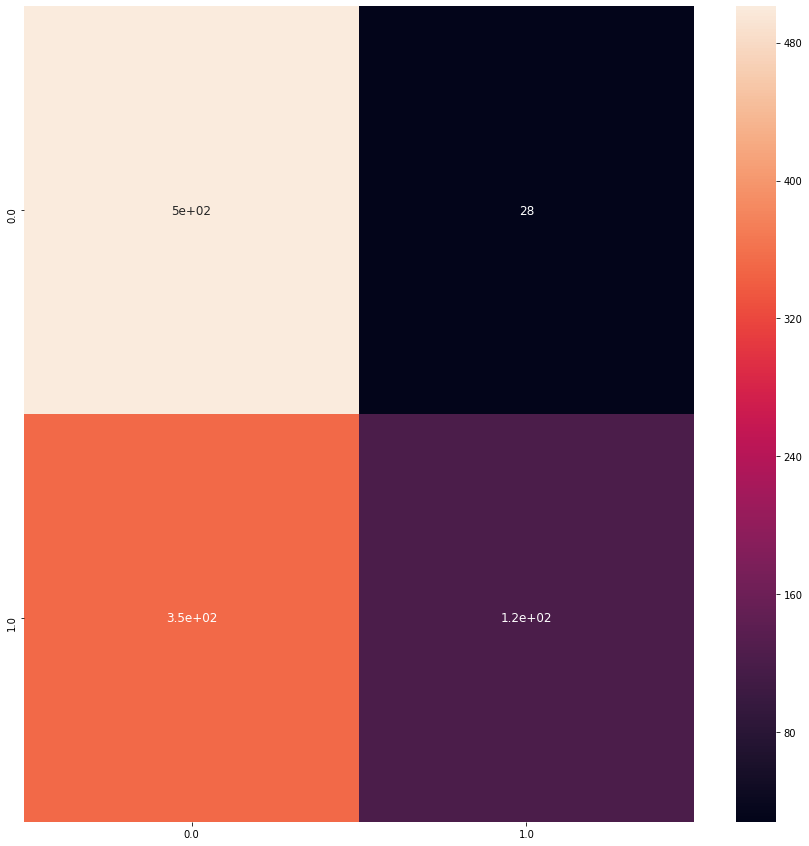

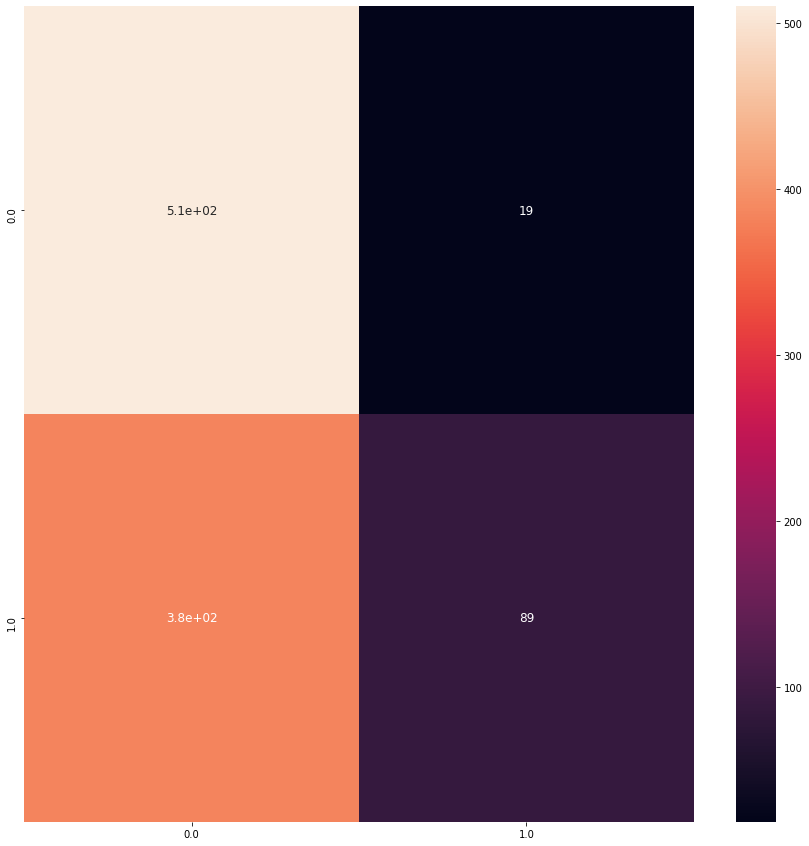

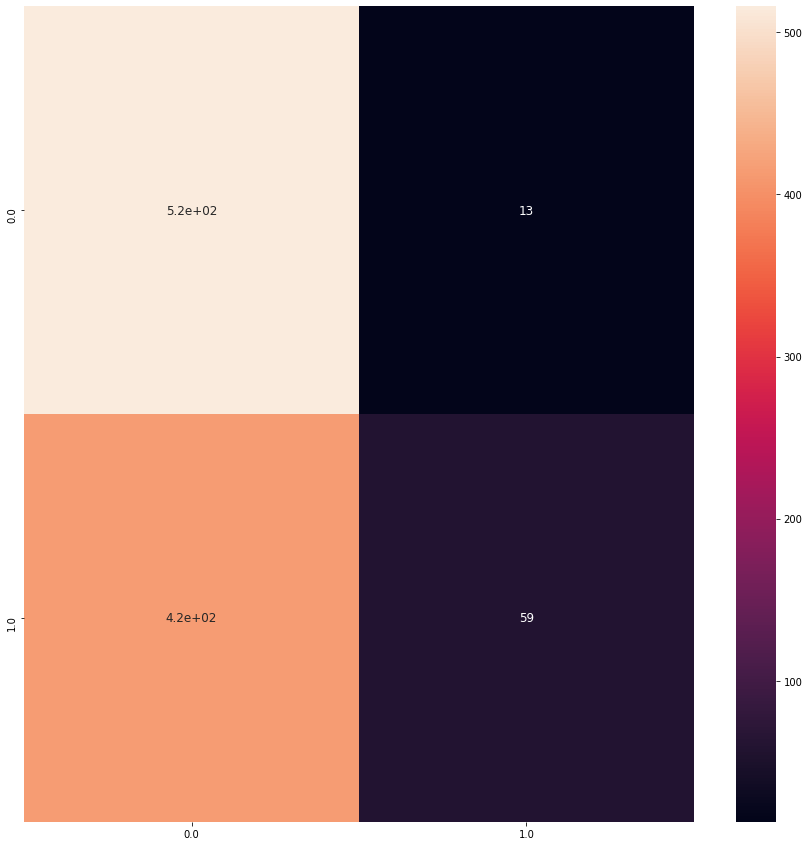

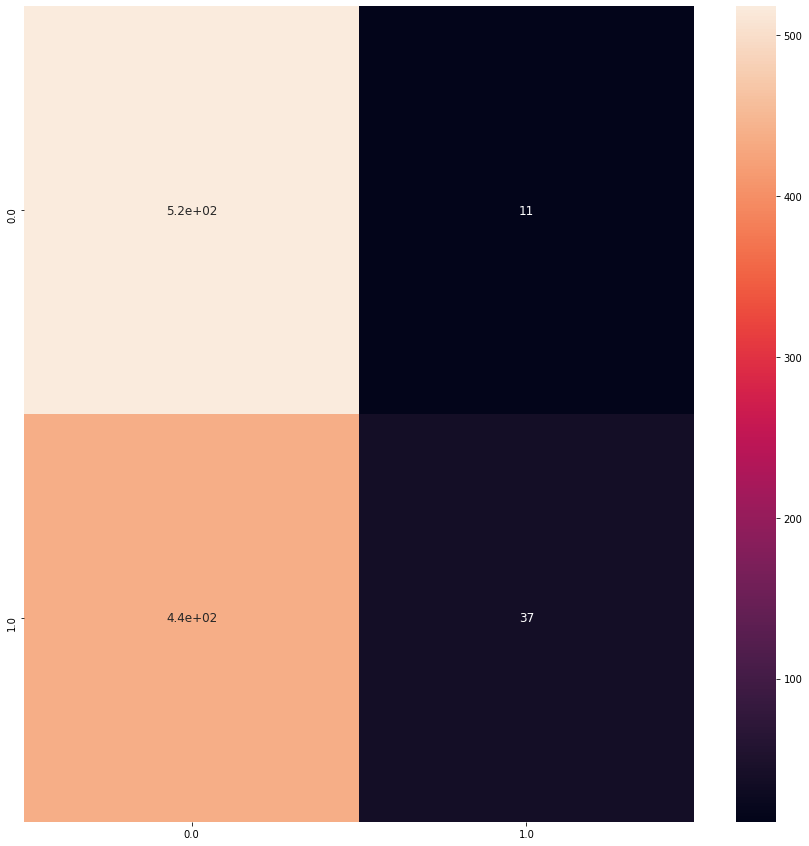

In [16]:
lista_k = [3,5,7,9,11]
list_accs = []
classification = []

for k in lista_k:
    y_pred = predictKNN(x_train, y_train, x_test, k, distance_euclidian)
    print("[KNN] Score K = ", k)
    #print(acc(y_test, y_pred))
    list_accs.append(acc(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    classification.append(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index = np.unique(y_test), columns = np.unique(y_test))

    plt.figure(figsize=(15,15))
    sb.heatmap(cm_df, annot=True, annot_kws={"size": 12})
    plt.savefig('KNN' + str(k) + '.png')

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index = np.unique(y_test), columns = np.unique(y_test))

plt.figure(figsize=(15,15))
sb.heatmap(cm_df, annot=True, annot_kws={"size": 12})
plt.savefig('KNN.png')

# 7. Avaliação de Resultados e Conclusão